# Preprocessing

In [6]:
def parse_dataset(length=256):
    directory = ""  #"latents\\" #"reconstruction_test_latents\\" #mtg-jamendo
    num_per = 1000
    count = 30
    #16150
    #for start in tqdm(range(16000, 31000, num_per)):
        #mtg_dataset, masks = retrieve_data("E:\SongsDataset\\mtg-jamendo\\", directory, start=start, count=num_per, sample_length=length)
        #torch.save(mtg_dataset, f"E:\\SongsDataset\\length_{length}\\dataset{count}.pt")
       # torch.save(masks, f"E:\\SongsDataset\\length_{length}\\dataset{count}-masks.pt")
       # count += 1

    # scount = 1
    # for start in tqdm(range(0, 3975, num_per)):
    #     spotify_dataset, masks  = retrieve_data("E:\\SongsDataset\\latents\\", directory, start=start, count=num_per, sample_length=length)
    #     torch.save(spotify_dataset, f"E:\\SongsDataset\\length_{length}\\dataset-spotify{scount}.pt")
    #     torch.save(masks, f"E:\\SongsDataset\\length_{length}\\dataset-spotify{scount}-masks.pt")
    #     scount += 1

    full_dataset = torch.load(f"E:\\SongsDataset\\length_{length}\\dataset1.pt")
    #full_masks = torch.load(f"E:\\SongsDataset\\length_{length}\\dataset1-masks.pt")

    for start in tqdm(range(2, count)):
        new_data = torch.load(f"E:\\SongsDataset\\length_{length}\\dataset{start}.pt")
        #new_masks = torch.load(f"E:\\SongsDataset\\length_{length}\\dataset{start}-masks.pt")

        full_dataset = torch.cat((full_dataset, new_data))
        #full_masks = torch.cat((full_masks, new_masks))

    # bool_masks = [[0 if (length - i) > x else 1 for i in range(length)] for x in full_masks]
    # bool_masks = torch.tensor(bool_masks).bool()

    torch.save(full_dataset, f"E:\\SongsDataset\\length_{length}\\full_mtg_dataset_extended.pt")
    # torch.save(bool_masks, f"E:\\SongsDataset\\length_{length}\\full_mtg_masks.pt")

In [ ]:
parse_dataset(256)

 86%|████████▌ | 24/28 [04:39<02:06, 31.54s/it]

# Data & Training

In [1]:
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

import torch

from Training import train, evaluate
from Data import AudioDataset, retrieve_data

In [2]:
# ==== Model & Optimizer ====
num_heads = 16
num_layers = 16
d_model = 512
latent_space = 512
dim_feedforward = 1024
sample_length = 256
projection_dim = 128
dropout = 0.1

batch_size = 30

device = "cuda"

In [3]:
from torch.utils.data import random_split, TensorDataset

#dataset = torch.load(f"E:\\SongsDataset\\length_{sample_length}\\full_mtg_dataset.pt")
dataset = torch.load(f"E:\\SongsDataset\\length_{sample_length}\\full_mtg_dataset_extended.pt")
#masks = torch.load(f"E:\\SongsDataset\\length_{sample_length}\\full_masks.pt")

#dataset = torch.load(f"E:\\SongsDataset\\length_{sample_length}\\dataset1.pt")[:1000]
#masks = torch.load(f"E:\\SongsDataset\\length_{sample_length}\\dataset1-masks.pt").bool()

In [4]:
num_samples, seq_length, embed_dim = dataset.shape

collective_dataset = AudioDataset(dataset)

train_len = int(len(collective_dataset) * 0.9)
train_set, test_set = random_split(collective_dataset, [train_len, len(collective_dataset) - train_len])

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [5]:
from Loss import combined_loss
from AudioVariationalTransformer import AudioVariationalTransformer

model = AudioVariationalTransformer(d_model=d_model, num_heads=num_heads, transformer_layers=num_layers, dim_feedforward=dim_feedforward, latent_space=latent_space, length=sample_length, dropout=dropout, name_extension="-fft-cos-mtg-only-FlashAttention-5-25-CNN", use_rope=True, use_alibi=True)
model.set_checkpointing(False)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

124851809


In [ ]:
# Variational Flash Attention Cyclical Modified More Losses
# Coeff 0.3, cycles of 5, 25 epochs, latent space of 128
# Changed Architecture and Losses
train(model, train_dataloader, test_dataloader, optimizer, cycle_length=15, coeff=0.01, num_epochs=30, device=device, loss_func=combined_loss)
evaluate(model, test_dataloader)

 46%|████▌     | 4507/9753 [14:19<14:44,  5.93it/s]

In [8]:
# Variational Flash Attention Cyclical Modified More Losses
# Coeff 0.3, cycles of 5, 25 epochs, latent space of 128
train(model, train_dataloader, test_dataloader, optimizer, cycle_length=5, coeff=0.3, num_epochs=25, device=device, loss_func=combined_loss)
evaluate(model, test_dataloader)

100%|██████████| 506/506 [00:24<00:00, 20.65it/s]


Epoch [1/25], Training Loss: 2.3975 	 Validation Losses:
KLD: 1668.4040	Cosine Similarity: 0.6316	Cross Coorelation: 0.7291	MSE: 0.7910


100%|██████████| 506/506 [00:24<00:00, 20.70it/s]


Epoch [2/25], Training Loss: 2.2154 	 Validation Losses:
KLD: 11.5019	Cosine Similarity: 0.6031	Cross Coorelation: 0.7194	MSE: 0.7781


100%|██████████| 506/506 [00:24<00:00, 20.44it/s]


Epoch [3/25], Training Loss: 2.1029 	 Validation Losses:
KLD: 2.8294	Cosine Similarity: 0.5722	Cross Coorelation: 0.7052	MSE: 0.7665


100%|██████████| 506/506 [00:24<00:00, 20.31it/s]


Epoch [4/25], Training Loss: 2.0381 	 Validation Losses:
KLD: 2.0968	Cosine Similarity: 0.5476	Cross Coorelation: 0.6916	MSE: 0.7572


100%|██████████| 506/506 [00:25<00:00, 19.55it/s]


Epoch [5/25], Training Loss: 1.9972 	 Validation Losses:
KLD: 36.2380	Cosine Similarity: 0.5298	Cross Coorelation: 0.6835	MSE: 0.7473


100%|██████████| 506/506 [00:24<00:00, 20.63it/s]


Epoch [6/25], Training Loss: 1.9456 	 Validation Losses:
KLD: 18.4180	Cosine Similarity: 0.5135	Cross Coorelation: 0.6695	MSE: 0.7383


100%|██████████| 506/506 [00:25<00:00, 20.14it/s]


Epoch [7/25], Training Loss: 1.9481 	 Validation Losses:
KLD: 1.0503	Cosine Similarity: 0.5141	Cross Coorelation: 0.6688	MSE: 0.7389


100%|██████████| 506/506 [00:26<00:00, 19.38it/s]


Epoch [8/25], Training Loss: 1.9386 	 Validation Losses:
KLD: 0.7651	Cosine Similarity: 0.5110	Cross Coorelation: 0.6655	MSE: 0.7392


100%|██████████| 506/506 [00:24<00:00, 20.84it/s]


Epoch [9/25], Training Loss: 1.9272 	 Validation Losses:
KLD: 0.6864	Cosine Similarity: 0.5057	Cross Coorelation: 0.6621	MSE: 0.7347


100%|██████████| 506/506 [00:24<00:00, 20.82it/s]


Epoch [10/25], Training Loss: 1.9134 	 Validation Losses:
KLD: 30.0507	Cosine Similarity: 0.5009	Cross Coorelation: 0.6596	MSE: 0.7323


100%|██████████| 506/506 [00:24<00:00, 20.88it/s]


Epoch [11/25], Training Loss: 1.8944 	 Validation Losses:
KLD: 1.9975	Cosine Similarity: 0.4969	Cross Coorelation: 0.6559	MSE: 0.7293


100%|██████████| 506/506 [00:24<00:00, 20.73it/s]


Epoch [12/25], Training Loss: 1.9020 	 Validation Losses:
KLD: 0.5682	Cosine Similarity: 0.4967	Cross Coorelation: 0.6559	MSE: 0.7295


100%|██████████| 506/506 [00:24<00:00, 20.75it/s]


Epoch [13/25], Training Loss: 1.8962 	 Validation Losses:
KLD: 0.4293	Cosine Similarity: 0.4951	Cross Coorelation: 0.6535	MSE: 0.7293


100%|██████████| 506/506 [00:24<00:00, 20.95it/s]


Epoch [14/25], Training Loss: 1.8911 	 Validation Losses:
KLD: 0.3940	Cosine Similarity: 0.4932	Cross Coorelation: 0.6526	MSE: 0.7278


100%|██████████| 506/506 [00:24<00:00, 20.95it/s]


Epoch [15/25], Training Loss: 1.8809 	 Validation Losses:
KLD: 12.0827	Cosine Similarity: 0.4885	Cross Coorelation: 0.6507	MSE: 0.7255


100%|██████████| 506/506 [00:24<00:00, 20.99it/s]


Epoch [16/25], Training Loss: 1.8741 	 Validation Losses:
KLD: 0.5255	Cosine Similarity: 0.4886	Cross Coorelation: 0.6498	MSE: 0.7257


100%|██████████| 506/506 [00:24<00:00, 21.01it/s]


Epoch [17/25], Training Loss: 1.8797 	 Validation Losses:
KLD: 0.3242	Cosine Similarity: 0.4887	Cross Coorelation: 0.6493	MSE: 0.7254


100%|██████████| 506/506 [00:24<00:00, 21.01it/s]


Epoch [18/25], Training Loss: 1.8766 	 Validation Losses:
KLD: 0.2785	Cosine Similarity: 0.4868	Cross Coorelation: 0.6484	MSE: 0.7241


100%|██████████| 506/506 [00:24<00:00, 21.00it/s]


Epoch [19/25], Training Loss: 1.8739 	 Validation Losses:
KLD: 0.2462	Cosine Similarity: 0.4858	Cross Coorelation: 0.6483	MSE: 0.7241


100%|██████████| 506/506 [00:24<00:00, 20.97it/s]


Epoch [20/25], Training Loss: 1.8651 	 Validation Losses:
KLD: 2.5046	Cosine Similarity: 0.4832	Cross Coorelation: 0.6470	MSE: 0.7229


100%|██████████| 506/506 [00:29<00:00, 16.98it/s]


Epoch [21/25], Training Loss: 1.8650 	 Validation Losses:
KLD: 0.2702	Cosine Similarity: 0.4836	Cross Coorelation: 0.6462	MSE: 0.7224


100%|██████████| 506/506 [00:24<00:00, 20.41it/s]


Epoch [22/25], Training Loss: 1.8690 	 Validation Losses:
KLD: 0.2205	Cosine Similarity: 0.4832	Cross Coorelation: 0.6461	MSE: 0.7223


100%|██████████| 506/506 [00:23<00:00, 21.22it/s]


Epoch [23/25], Training Loss: 1.8679 	 Validation Losses:
KLD: 0.2049	Cosine Similarity: 0.4829	Cross Coorelation: 0.6458	MSE: 0.7221


100%|██████████| 506/506 [00:23<00:00, 21.27it/s]


Epoch [24/25], Training Loss: 1.8672 	 Validation Losses:
KLD: 0.1971	Cosine Similarity: 0.4830	Cross Coorelation: 0.6459	MSE: 0.7222


100%|██████████| 506/506 [00:23<00:00, 21.31it/s]


Epoch [25/25], Training Loss: 1.8610 	 Validation Losses:
KLD: 0.2691	Cosine Similarity: 0.4828	Cross Coorelation: 0.6462	MSE: 0.7221


100%|██████████| 506/506 [00:23<00:00, 21.28it/s]

Avg Reconstructive Loss: 0.4828064509
Avg Cross FFT Loss: 0.6461752092
Avg KLD Loss: 136.1856895089


137.31467116903883

In [24]:
from matplotlib import pyplot as plt
import torch.nn.functional as F

def diagnose_posterior_collapse(model, dataloader, device='cuda'):
    with torch.no_grad():
        model.eval()
        similarities = []
        latent_vars = []


        for batch in tqdm(dataloader):
            x = batch.to(device)

            # Encode
            z_mu, z_logvar = model.to_latent(x, None)
            z1 = model.reparameterization(z_mu, z_logvar)
            z2 = model.reparameterization(z_mu, z_logvar)  # second sample for same input

            # Decode
            x1 = model.from_latent(z1, None)
            x2 = model.from_latent(z2, None)

            # Flatten and compute cosine similarity
            sim = F.cosine_similarity(x1.view(x1.size(0), -1), x2.view(x2.size(0), -1), dim=1)
            similarities.append(sim.cpu())

            # Track variance of latent dimensions
            latent_vars.append(z1.cpu())

    similarities = torch.cat(similarities)
    latent_vars = torch.cat(latent_vars)

    print(f"\n🔍 Posterior Collapse Diagnostic:")
    print(f"  Avg cosine similarity (sampled reconstructions): {similarities.mean().item():.4f}")
    print(f"  Std of latent dimensions (should NOT all be ~1):")

    stds = latent_vars.std(dim=0)
    for i, std in enumerate(stds):
        print(f"    z[{i}]: std={std:.4f}")

    # Optional: visualize
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(similarities.numpy(), bins=30)
    plt.title("Cosine similarity between reconstructions")
    plt.subplot(1, 2, 2)
    plt.bar(range(len(stds)), stds)
    plt.title("Std of latent dimensions")
    plt.tight_layout()
    plt.show()

100%|██████████| 506/506 [00:37<00:00, 13.55it/s]



🔍 Posterior Collapse Diagnostic:
  Avg cosine similarity (sampled reconstructions): 0.9965
  Std of latent dimensions (should NOT all be ~1):
    z[0]: std=0.0115
    z[1]: std=0.0102
    z[2]: std=0.0114
    z[3]: std=0.0101
    z[4]: std=0.0101
    z[5]: std=0.0102
    z[6]: std=0.0107
    z[7]: std=0.0101
    z[8]: std=0.0108
    z[9]: std=0.0115
    z[10]: std=0.0103
    z[11]: std=0.0103
    z[12]: std=0.0107
    z[13]: std=0.0100
    z[14]: std=0.0096
    z[15]: std=0.0119
    z[16]: std=0.0114
    z[17]: std=0.0110
    z[18]: std=0.0098
    z[19]: std=0.0104
    z[20]: std=0.0098
    z[21]: std=0.0104
    z[22]: std=0.0109
    z[23]: std=0.0104
    z[24]: std=0.0106
    z[25]: std=0.0109
    z[26]: std=0.0102
    z[27]: std=0.0106
    z[28]: std=0.0101
    z[29]: std=0.0113
    z[30]: std=0.0101
    z[31]: std=0.0104
    z[32]: std=0.0127
    z[33]: std=0.0104
    z[34]: std=0.0107
    z[35]: std=0.0110
    z[36]: std=0.0106
    z[37]: std=0.0096
    z[38]: std=0.0095
    z[39]

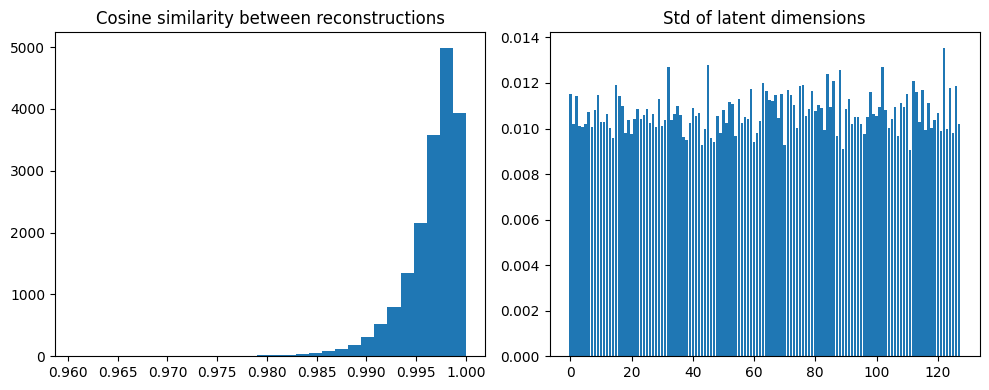

In [25]:
diagnose_posterior_collapse(model, test_dataloader)

100%|██████████| 4551/4551 [05:36<00:00, 13.51it/s]



🔍 Posterior Collapse Diagnostic:
  Avg cosine similarity (sampled reconstructions): 0.9965
  Std of latent dimensions (should NOT all be ~1):
    z[0]: std=0.0115
    z[1]: std=0.0101
    z[2]: std=0.0115
    z[3]: std=0.0102
    z[4]: std=0.0101
    z[5]: std=0.0101
    z[6]: std=0.0107
    z[7]: std=0.0101
    z[8]: std=0.0108
    z[9]: std=0.0114
    z[10]: std=0.0103
    z[11]: std=0.0103
    z[12]: std=0.0107
    z[13]: std=0.0100
    z[14]: std=0.0096
    z[15]: std=0.0120
    z[16]: std=0.0115
    z[17]: std=0.0110
    z[18]: std=0.0098
    z[19]: std=0.0103
    z[20]: std=0.0098
    z[21]: std=0.0104
    z[22]: std=0.0110
    z[23]: std=0.0104
    z[24]: std=0.0105
    z[25]: std=0.0109
    z[26]: std=0.0102
    z[27]: std=0.0106
    z[28]: std=0.0101
    z[29]: std=0.0113
    z[30]: std=0.0101
    z[31]: std=0.0105
    z[32]: std=0.0127
    z[33]: std=0.0104
    z[34]: std=0.0106
    z[35]: std=0.0110
    z[36]: std=0.0106
    z[37]: std=0.0097
    z[38]: std=0.0096
    z[39]

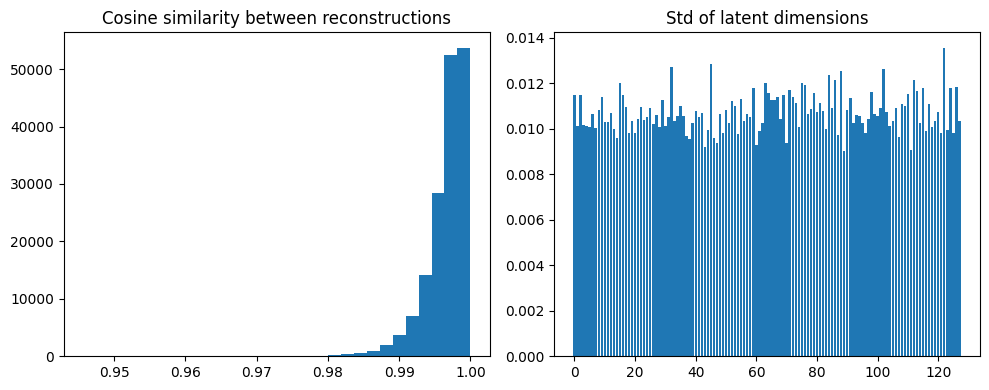

In [26]:
diagnose_posterior_collapse(model, train_dataloader)

In [8]:
# Variational Flash Attention Cyclical Modified
# Coeff 0.3, cycles of 5, 25 epochs
train(model, train_dataloader, test_dataloader, optimizer, cycle_length=5, coeff=0.3, num_epochs=25, device=device, loss_func=combined_loss)
evaluate(model, test_dataloader)

100%|██████████| 506/506 [00:23<00:00, 21.62it/s]


Epoch [1/25], Training Loss: 1.4659 	 Validation Losses:
KLD: 2096.9374	Cosine Similarity: 0.5981	Cross Coorelation: 0.7140


100%|██████████| 506/506 [00:23<00:00, 21.72it/s]


Epoch [2/25], Training Loss: 1.3465 	 Validation Losses:
KLD: 5.4048	Cosine Similarity: 0.5670	Cross Coorelation: 0.7004


100%|██████████| 506/506 [00:23<00:00, 21.75it/s]


Epoch [3/25], Training Loss: 1.2406 	 Validation Losses:
KLD: 3.0111	Cosine Similarity: 0.5106	Cross Coorelation: 0.6663


100%|██████████| 506/506 [00:23<00:00, 21.72it/s]


Epoch [4/25], Training Loss: 1.1807 	 Validation Losses:
KLD: 2.3831	Cosine Similarity: 0.4909	Cross Coorelation: 0.6500


100%|██████████| 506/506 [00:23<00:00, 21.57it/s]


Epoch [5/25], Training Loss: 1.1409 	 Validation Losses:
KLD: 100.0427	Cosine Similarity: 0.4714	Cross Coorelation: 0.6303


100%|██████████| 506/506 [00:23<00:00, 21.74it/s]


Epoch [6/25], Training Loss: 1.0802 	 Validation Losses:
KLD: 19.4910	Cosine Similarity: 0.4432	Cross Coorelation: 0.6089


100%|██████████| 506/506 [00:23<00:00, 21.74it/s]


Epoch [7/25], Training Loss: 1.0829 	 Validation Losses:
KLD: 1.5605	Cosine Similarity: 0.4439	Cross Coorelation: 0.6079


100%|██████████| 506/506 [00:23<00:00, 21.68it/s]


Epoch [8/25], Training Loss: 1.0723 	 Validation Losses:
KLD: 1.3643	Cosine Similarity: 0.4382	Cross Coorelation: 0.6027


100%|██████████| 506/506 [00:23<00:00, 21.69it/s]


Epoch [9/25], Training Loss: 1.0584 	 Validation Losses:
KLD: 1.1441	Cosine Similarity: 0.4328	Cross Coorelation: 0.5952


100%|██████████| 506/506 [00:23<00:00, 21.72it/s]


Epoch [10/25], Training Loss: 1.0403 	 Validation Losses:
KLD: 36.5079	Cosine Similarity: 0.4230	Cross Coorelation: 0.5861


100%|██████████| 506/506 [00:23<00:00, 21.80it/s]


Epoch [11/25], Training Loss: 1.0152 	 Validation Losses:
KLD: 2.6248	Cosine Similarity: 0.4167	Cross Coorelation: 0.5786


100%|██████████| 506/506 [00:23<00:00, 21.79it/s]


Epoch [12/25], Training Loss: 1.0230 	 Validation Losses:
KLD: 0.9594	Cosine Similarity: 0.4185	Cross Coorelation: 0.5779


100%|██████████| 506/506 [00:23<00:00, 21.76it/s]


Epoch [13/25], Training Loss: 1.0156 	 Validation Losses:
KLD: 0.7622	Cosine Similarity: 0.4137	Cross Coorelation: 0.5742


100%|██████████| 506/506 [00:23<00:00, 21.71it/s]


Epoch [14/25], Training Loss: 1.0086 	 Validation Losses:
KLD: 0.6407	Cosine Similarity: 0.4120	Cross Coorelation: 0.5715


100%|██████████| 506/506 [00:23<00:00, 21.74it/s]


Epoch [15/25], Training Loss: 0.9948 	 Validation Losses:
KLD: 7.5179	Cosine Similarity: 0.4064	Cross Coorelation: 0.5677


100%|██████████| 506/506 [00:23<00:00, 21.76it/s]


Epoch [16/25], Training Loss: 0.9852 	 Validation Losses:
KLD: 0.7667	Cosine Similarity: 0.4053	Cross Coorelation: 0.5652


100%|██████████| 506/506 [00:23<00:00, 21.76it/s]


Epoch [17/25], Training Loss: 0.9919 	 Validation Losses:
KLD: 0.4904	Cosine Similarity: 0.4039	Cross Coorelation: 0.5635


100%|██████████| 506/506 [00:23<00:00, 21.67it/s]


Epoch [18/25], Training Loss: 0.9880 	 Validation Losses:
KLD: 0.4418	Cosine Similarity: 0.4031	Cross Coorelation: 0.5627


100%|██████████| 506/506 [00:23<00:00, 21.75it/s]


Epoch [19/25], Training Loss: 0.9846 	 Validation Losses:
KLD: 0.3698	Cosine Similarity: 0.4014	Cross Coorelation: 0.5613


100%|██████████| 506/506 [00:23<00:00, 21.70it/s]


Epoch [20/25], Training Loss: 0.9735 	 Validation Losses:
KLD: 2.7572	Cosine Similarity: 0.3999	Cross Coorelation: 0.5603


100%|██████████| 506/506 [00:23<00:00, 21.76it/s]


Epoch [21/25], Training Loss: 0.9735 	 Validation Losses:
KLD: 0.3892	Cosine Similarity: 0.3990	Cross Coorelation: 0.5591


100%|██████████| 506/506 [00:23<00:00, 21.73it/s]


Epoch [22/25], Training Loss: 0.9787 	 Validation Losses:
KLD: 0.3236	Cosine Similarity: 0.3990	Cross Coorelation: 0.5589


100%|██████████| 506/506 [00:23<00:00, 21.74it/s]


Epoch [23/25], Training Loss: 0.9772 	 Validation Losses:
KLD: 0.2907	Cosine Similarity: 0.3986	Cross Coorelation: 0.5588


100%|██████████| 506/506 [00:23<00:00, 21.74it/s]


Epoch [24/25], Training Loss: 0.9765 	 Validation Losses:
KLD: 0.2802	Cosine Similarity: 0.3983	Cross Coorelation: 0.5585


100%|██████████| 506/506 [00:23<00:00, 21.74it/s]


Epoch [25/25], Training Loss: 0.9680 	 Validation Losses:
KLD: 0.5649	Cosine Similarity: 0.3981	Cross Coorelation: 0.5588


100%|██████████| 506/506 [00:25<00:00, 20.15it/s]

Avg Reconstructive Loss: 0.3981332791
Avg Cross FFT Loss: 0.5587440845
Avg KLD Loss: 285.8182881773


286.77516554078096

In [8]:
# Variational Flash Attention Cyclical Modified
# Coeff 0.1, cycles of 3, 27 epochs
train(model, train_dataloader, test_dataloader, optimizer, cycle_length=5, num_epochs=25, device=device, loss_func=combined_loss)
evaluate(model, test_dataloader)

100%|██████████| 506/506 [00:22<00:00, 22.17it/s]


Epoch [1/27], Training Loss: 1.4703 	 Validation Losses:
KLD: 7177.8987	Cosine Similarity: 0.6078	Cross Coorelation: 0.7160


100%|██████████| 506/506 [00:23<00:00, 21.68it/s]


Epoch [2/27], Training Loss: 1.3440 	 Validation Losses:
KLD: 42.6100	Cosine Similarity: 0.5658	Cross Coorelation: 0.6970


100%|██████████| 506/506 [00:28<00:00, 18.01it/s]


Epoch [3/27], Training Loss: 1.2533 	 Validation Losses:
KLD: 20.0302	Cosine Similarity: 0.5240	Cross Coorelation: 0.6696


100%|██████████| 506/506 [00:23<00:00, 21.40it/s]


Epoch [4/27], Training Loss: 1.1556 	 Validation Losses:
KLD: 1717.6994	Cosine Similarity: 0.4759	Cross Coorelation: 0.6295


100%|██████████| 506/506 [00:28<00:00, 17.86it/s]


Epoch [5/27], Training Loss: 1.1198 	 Validation Losses:
KLD: 8.2819	Cosine Similarity: 0.4757	Cross Coorelation: 0.6255


100%|██████████| 506/506 [00:29<00:00, 17.11it/s]


Epoch [6/27], Training Loss: 1.1093 	 Validation Losses:
KLD: 5.5196	Cosine Similarity: 0.4615	Cross Coorelation: 0.6121


100%|██████████| 506/506 [00:29<00:00, 17.34it/s]


Epoch [7/27], Training Loss: 1.0710 	 Validation Losses:
KLD: 1159.9098	Cosine Similarity: 0.4429	Cross Coorelation: 0.5955


100%|██████████| 506/506 [00:22<00:00, 22.43it/s]


Epoch [8/27], Training Loss: 1.0512 	 Validation Losses:
KLD: 5.0563	Cosine Similarity: 0.4435	Cross Coorelation: 0.5910


100%|██████████| 506/506 [00:26<00:00, 18.92it/s]


Epoch [9/27], Training Loss: 1.0511 	 Validation Losses:
KLD: 3.4026	Cosine Similarity: 0.4367	Cross Coorelation: 0.5862


100%|██████████| 506/506 [00:26<00:00, 19.07it/s]


Epoch [10/27], Training Loss: 1.0307 	 Validation Losses:
KLD: 665.8492	Cosine Similarity: 0.4293	Cross Coorelation: 0.5783


100%|██████████| 506/506 [00:28<00:00, 17.72it/s]


Epoch [11/27], Training Loss: 1.0154 	 Validation Losses:
KLD: 3.8499	Cosine Similarity: 0.4276	Cross Coorelation: 0.5746


100%|██████████| 506/506 [00:37<00:00, 13.63it/s]


Epoch [12/27], Training Loss: 1.0182 	 Validation Losses:
KLD: 2.5155	Cosine Similarity: 0.4236	Cross Coorelation: 0.5706


100%|██████████| 506/506 [00:27<00:00, 18.13it/s]


Epoch [13/27], Training Loss: 1.0056 	 Validation Losses:
KLD: 17.7569	Cosine Similarity: 0.4205	Cross Coorelation: 0.5678


100%|██████████| 506/506 [00:27<00:00, 18.39it/s]


Epoch [14/27], Training Loss: 0.9954 	 Validation Losses:
KLD: 2.8769	Cosine Similarity: 0.4170	Cross Coorelation: 0.5641


100%|██████████| 506/506 [00:27<00:00, 18.31it/s]


Epoch [15/27], Training Loss: 0.9993 	 Validation Losses:
KLD: 1.7062	Cosine Similarity: 0.4169	Cross Coorelation: 0.5636


100%|██████████| 506/506 [00:30<00:00, 16.86it/s]


Epoch [16/27], Training Loss: 0.9918 	 Validation Losses:
KLD: 8.5115	Cosine Similarity: 0.4143	Cross Coorelation: 0.5606


100%|██████████| 506/506 [00:22<00:00, 22.29it/s]


Epoch [17/27], Training Loss: 0.9824 	 Validation Losses:
KLD: 3.0427	Cosine Similarity: 0.4130	Cross Coorelation: 0.5586


100%|██████████| 506/506 [00:28<00:00, 17.46it/s]


Epoch [18/27], Training Loss: 0.9865 	 Validation Losses:
KLD: 1.2683	Cosine Similarity: 0.4128	Cross Coorelation: 0.5587


100%|██████████| 506/506 [00:29<00:00, 16.92it/s]


Epoch [19/27], Training Loss: 0.9823 	 Validation Losses:
KLD: 5.4231	Cosine Similarity: 0.4116	Cross Coorelation: 0.5576


100%|██████████| 506/506 [00:29<00:00, 16.89it/s]


Epoch [20/27], Training Loss: 0.9741 	 Validation Losses:
KLD: 3.4889	Cosine Similarity: 0.4099	Cross Coorelation: 0.5560


100%|██████████| 506/506 [00:27<00:00, 18.27it/s]


Epoch [21/27], Training Loss: 0.9784 	 Validation Losses:
KLD: 0.8991	Cosine Similarity: 0.4090	Cross Coorelation: 0.5549


100%|██████████| 506/506 [00:30<00:00, 16.81it/s]


Epoch [22/27], Training Loss: 0.9768 	 Validation Losses:
KLD: 2.8731	Cosine Similarity: 0.4092	Cross Coorelation: 0.5548


100%|██████████| 506/506 [00:26<00:00, 19.06it/s]


Epoch [23/27], Training Loss: 0.9692 	 Validation Losses:
KLD: 2.8398	Cosine Similarity: 0.4078	Cross Coorelation: 0.5539


100%|██████████| 506/506 [00:25<00:00, 20.22it/s]


Epoch [24/27], Training Loss: 0.9737 	 Validation Losses:
KLD: 0.7841	Cosine Similarity: 0.4074	Cross Coorelation: 0.5536


100%|██████████| 506/506 [00:24<00:00, 20.24it/s]


Epoch [25/27], Training Loss: 0.9746 	 Validation Losses:
KLD: 1.3063	Cosine Similarity: 0.4075	Cross Coorelation: 0.5538


100%|██████████| 506/506 [00:24<00:00, 20.26it/s]


Epoch [26/27], Training Loss: 0.9674 	 Validation Losses:
KLD: 2.0533	Cosine Similarity: 0.4071	Cross Coorelation: 0.5534


100%|██████████| 506/506 [00:25<00:00, 20.18it/s]


Epoch [27/27], Training Loss: 0.9724 	 Validation Losses:
KLD: 1.0926	Cosine Similarity: 0.4074	Cross Coorelation: 0.5528


100%|██████████| 506/506 [00:28<00:00, 17.64it/s]

Avg Reconstructive Loss: 0.4074090921
Avg Cross FFT Loss: 0.5527993047
Avg KLD Loss: 552.8645509481


553.8247593449274

In [7]:
# Variational Flash Attention Cyclical
train(model, train_dataloader, test_dataloader, optimizer, cycle_length=3, num_epochs=27, device=device, loss_func=combined_loss)
evaluate(model, test_dataloader)

100%|██████████| 506/506 [00:28<00:00, 17.53it/s]


Epoch [1/25], Training Loss: 1.4636 	 Validation Losses:
KLD: 28125.8300	Cosine Similarity: 0.5894	Cross Coorelation: 0.7125


100%|██████████| 506/506 [00:30<00:00, 16.50it/s]


Epoch [2/25], Training Loss: 1.2612 	 Validation Losses:
KLD: 47554.1858	Cosine Similarity: 0.5164	Cross Coorelation: 0.6755


100%|██████████| 506/506 [00:24<00:00, 20.77it/s]


Epoch [3/25], Training Loss: 1.1683 	 Validation Losses:
KLD: 57272.0594	Cosine Similarity: 0.4830	Cross Coorelation: 0.6475


100%|██████████| 506/506 [00:24<00:00, 20.64it/s]


Epoch [4/25], Training Loss: 1.1178 	 Validation Losses:
KLD: 67691.1982	Cosine Similarity: 0.4598	Cross Coorelation: 0.6283


100%|██████████| 506/506 [00:23<00:00, 21.95it/s]


Epoch [5/25], Training Loss: 1.0834 	 Validation Losses:
KLD: 67182.2670	Cosine Similarity: 0.4473	Cross Coorelation: 0.6142


100%|██████████| 506/506 [00:22<00:00, 22.46it/s]


Epoch [6/25], Training Loss: 1.0597 	 Validation Losses:
KLD: 63611.6682	Cosine Similarity: 0.4363	Cross Coorelation: 0.6033


100%|██████████| 506/506 [00:24<00:00, 20.26it/s]


Epoch [7/25], Training Loss: 1.0423 	 Validation Losses:
KLD: 56446.3172	Cosine Similarity: 0.4291	Cross Coorelation: 0.5954


 22%|██▏       | 994/4551 [02:41<09:37,  6.16it/s]


KeyboardInterrupt: 

In [10]:
# Variational Cyclical
train(model, train_dataloader, test_dataloader, optimizer, num_epochs=10, device=device, loss_func=combined_loss)
evaluate(model, test_dataloader)

  0%|          | 0/38 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [7]:
# Variational
train(model, train_dataloader, test_dataloader, optimizer, num_epochs=10, device=device, loss_func=combined_loss)
evaluate(model, test_dataloader)

100%|██████████| 1821/1821 [01:54<00:00, 15.96it/s]


Epoch [1/10], Training Loss: 1.4790 	 Validation Losses:
KLD: 1.2940	Cosine Similarity: 0.6675	Cross Coorelation: 0.7226


100%|██████████| 1821/1821 [01:51<00:00, 16.36it/s]


Epoch [2/10], Training Loss: 1.4033 	 Validation Losses:
KLD: 0.6997	Cosine Similarity: 0.6494	Cross Coorelation: 0.7195


100%|██████████| 1821/1821 [01:50<00:00, 16.41it/s]


Epoch [3/10], Training Loss: 1.3962 	 Validation Losses:
KLD: 0.2606	Cosine Similarity: 0.6267	Cross Coorelation: 0.7036


100%|██████████| 1821/1821 [01:51<00:00, 16.40it/s]


Epoch [4/10], Training Loss: 1.3747 	 Validation Losses:
KLD: 0.1018	Cosine Similarity: 0.6088	Cross Coorelation: 0.6989


100%|██████████| 1821/1821 [01:50<00:00, 16.41it/s]


Epoch [5/10], Training Loss: 1.3569 	 Validation Losses:
KLD: 0.0777	Cosine Similarity: 0.6003	Cross Coorelation: 0.6993


100%|██████████| 1821/1821 [01:50<00:00, 16.41it/s]


Epoch [6/10], Training Loss: 1.3318 	 Validation Losses:
KLD: 0.0479	Cosine Similarity: 0.5813	Cross Coorelation: 0.6960


100%|██████████| 1821/1821 [01:51<00:00, 16.28it/s]


Epoch [7/10], Training Loss: 1.2955 	 Validation Losses:
KLD: 0.0302	Cosine Similarity: 0.5568	Cross Coorelation: 0.6881


100%|██████████| 1821/1821 [02:33<00:00, 11.87it/s]


Epoch [8/10], Training Loss: 1.2558 	 Validation Losses:
KLD: 0.0179	Cosine Similarity: 0.5390	Cross Coorelation: 0.6777


100%|██████████| 1821/1821 [01:55<00:00, 15.75it/s]


Epoch [9/10], Training Loss: 1.2292 	 Validation Losses:
KLD: 0.0101	Cosine Similarity: 0.5286	Cross Coorelation: 0.6716


100%|██████████| 1821/1821 [01:56<00:00, 15.67it/s]


Epoch [10/10], Training Loss: 1.2154 	 Validation Losses:
KLD: 0.0077	Cosine Similarity: 0.5260	Cross Coorelation: 0.6699


100%|██████████| 1821/1821 [01:56<00:00, 15.66it/s]

Avg Reconstructive Loss: 0.5259646970
Avg Cross FFT Loss: 0.6698361217
Avg KLD Loss: 14.0500986278


15.245899446566376

In [4]:
model = torch.load(
    f"E:\Coding\SongAnalyzer\Analyzer\src\AudioVariationalTransformer-LatentSpace512-Heads16-TrasformerLayers16-DModel256-Dropout0.1-fft-cos-mtg-only\-Epoch-10.pt",
        weights_only=False)
evaluate(model, test_dataloader)

100%|██████████| 1821/1821 [01:53<00:00, 16.06it/s]

Avg Reconstructive Loss: 0.7702848709
Avg Cross FFT Loss: 0.7111858982
Avg KLD Loss: 5.6039851308


7.085455899870965

In [7]:
# Latent Space Normalization
train(model, train_dataloader, test_dataloader, optimizer, num_epochs=10, device=device, loss_func=combined_loss)
evaluate(model, test_dataloader)

100%|██████████| 1821/1821 [02:07<00:00, 14.26it/s]


Epoch [1/10], Training Loss: 1.3419 	 Validation Loss: 1.1311


100%|██████████| 1821/1821 [02:17<00:00, 13.25it/s]


Epoch [2/10], Training Loss: 1.0507 	 Validation Loss: 0.9707


100%|██████████| 1821/1821 [01:52<00:00, 16.19it/s]


Epoch [3/10], Training Loss: 0.9594 	 Validation Loss: 0.9291


100%|██████████| 1821/1821 [02:08<00:00, 14.21it/s]


Epoch [4/10], Training Loss: 0.9327 	 Validation Loss: 0.9161


100%|██████████| 1821/1821 [01:59<00:00, 15.28it/s]


Epoch [5/10], Training Loss: 0.9178 	 Validation Loss: 0.9061


100%|██████████| 1821/1821 [01:58<00:00, 15.36it/s]


Epoch [6/10], Training Loss: 0.9082 	 Validation Loss: 0.9012


100%|██████████| 1821/1821 [01:57<00:00, 15.45it/s]


Epoch [7/10], Training Loss: 0.9016 	 Validation Loss: 0.8962


100%|██████████| 1821/1821 [02:40<00:00, 11.37it/s]


Epoch [8/10], Training Loss: 0.8970 	 Validation Loss: 0.8939


100%|██████████| 1821/1821 [01:55<00:00, 15.74it/s]


Epoch [9/10], Training Loss: 0.8942 	 Validation Loss: 0.8921


100%|██████████| 1821/1821 [02:00<00:00, 15.08it/s]


Epoch [10/10], Training Loss: 0.8929 	 Validation Loss: 0.8917


  0%|          | 0/1821 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [7]:
# Mtg-Dataset Only
train(model, train_dataloader, test_dataloader, optimizer, num_epochs=10, device=device, loss_func=combined_loss)
evaluate(model, test_dataloader)

100%|██████████| 1821/1821 [01:51<00:00, 16.28it/s]


Epoch [1/10], Training Loss: 1.3380 	 Validation Loss: 1.1344


100%|██████████| 1821/1821 [01:51<00:00, 16.30it/s]


Epoch [2/10], Training Loss: 1.0710 	 Validation Loss: 0.9901


100%|██████████| 1821/1821 [01:51<00:00, 16.29it/s]


Epoch [3/10], Training Loss: 0.9821 	 Validation Loss: 0.9403


100%|██████████| 1821/1821 [01:51<00:00, 16.29it/s]


Epoch [4/10], Training Loss: 0.9483 	 Validation Loss: 0.9182


100%|██████████| 1821/1821 [01:51<00:00, 16.27it/s]


Epoch [5/10], Training Loss: 0.9291 	 Validation Loss: 0.9082


100%|██████████| 1821/1821 [01:51<00:00, 16.27it/s]


Epoch [6/10], Training Loss: 0.9183 	 Validation Loss: 0.9002


100%|██████████| 1821/1821 [01:51<00:00, 16.30it/s]


Epoch [7/10], Training Loss: 0.9108 	 Validation Loss: 0.8949


100%|██████████| 1821/1821 [01:54<00:00, 15.96it/s]


Epoch [8/10], Training Loss: 0.9056 	 Validation Loss: 0.8919


100%|██████████| 1821/1821 [02:01<00:00, 15.02it/s]


Epoch [9/10], Training Loss: 0.9023 	 Validation Loss: 0.8902


 32%|███▏      | 5228/16383 [17:28<37:16,  4.99it/s]  


KeyboardInterrupt: 

In [7]:
#Bidirectional
train(model, train_dataloader, test_dataloader, optimizer, num_epochs=10, device=device, loss_func=combined_loss)
evaluate(model, test_dataloader)

100%|██████████| 2059/2059 [02:20<00:00, 14.61it/s]


Epoch [1/10], Training Loss: 1.2469 	 Validation Loss: 1.0335


100%|██████████| 2059/2059 [02:18<00:00, 14.92it/s]


Epoch [2/10], Training Loss: 0.9888 	 Validation Loss: 0.9329


100%|██████████| 2059/2059 [02:18<00:00, 14.90it/s]


Epoch [3/10], Training Loss: 0.9290 	 Validation Loss: 0.9062


100%|██████████| 2059/2059 [02:18<00:00, 14.92it/s]


Epoch [4/10], Training Loss: 0.9082 	 Validation Loss: 0.8942


100%|██████████| 2059/2059 [02:17<00:00, 14.96it/s]


Epoch [5/10], Training Loss: 0.8955 	 Validation Loss: 0.8846


100%|██████████| 2059/2059 [02:32<00:00, 13.51it/s]


Epoch [6/10], Training Loss: 0.8862 	 Validation Loss: 0.8774


100%|██████████| 2059/2059 [02:22<00:00, 14.44it/s]


Epoch [7/10], Training Loss: 0.8790 	 Validation Loss: 0.8716


100%|██████████| 2059/2059 [02:38<00:00, 13.02it/s]


Epoch [8/10], Training Loss: 0.8738 	 Validation Loss: 0.8681


100%|██████████| 2059/2059 [02:36<00:00, 13.17it/s]


Epoch [9/10], Training Loss: 0.8704 	 Validation Loss: 0.8661


100%|██████████| 2059/2059 [02:17<00:00, 14.97it/s]


Epoch [10/10], Training Loss: 0.8688 	 Validation Loss: 0.8656


100%|██████████| 2059/2059 [02:16<00:00, 15.06it/s]


Avg Reconstructive Loss: 0.3636277616
Avg Cross FFT Loss: 0.5019369721
Avg Contrastive Loss: 0.8655653000


tensor(1.7311, device='cuda:0')

# Output Stuff

In [2]:
from torch.utils.data import random_split

reconstruction_examples = retrieve_data("E:\SongsDataset\\",  "reconstruction_test_latents\\", sample_length=256)

E:\Coding\SongAnalyzer\Analyzer\src\Data.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  tens = torch.tensor(dataset).to(torch.float32)


In [3]:
song_set, _ = random_split(reconstruction_examples, [len(reconstruction_examples), 0])
song_dataset = AudioDataset(song_set)
song_dataloader = DataLoader(song_dataset, batch_size=batch_size, shuffle=True)

TypeError: AudioDataset.__init__() missing 1 required positional argument: 'masks'

In [2]:
model = torch.load(
    f"E:\Coding\SongAnalyzer\Analyzer\src\AudioTransformer-LatentSpace512-Heads16-TrasformerLayers16-DModel256-Dropout0.1-fft-cos-bidirectional\-Epoch-10.pt",
        weights_only=False)
evaluate(model, song_dataset)

NameError: name 'song_dataset' is not defined

In [ ]:
from Loss import combined_loss

device = "cuda"

model.eval()  # Set model to evaluation mode
model.to(device)
total_loss = 0.0
num_batches = 0

new_song = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in tqdm(song_dataloader):
        batch = batch.to(device)

        # Forward pass
        reconstructed = model(batch)

        new_song.extend(reconstructed.to("cpu"))

        loss = combined_loss(reconstructed, batch)

        total_loss += loss.item()
        num_batches += 1

l = np.array(np.stack(new_song)).reshape(64, -1)
np.save("bidirectional-test.npy", l)

In [ ]:
device = "cuda"

model.eval()
model.to(device)

total_loss = 0.0
num_batches = 0

latent_space = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in tqdm(song_dataloader):
        batch = batch.to(device)

        # Forward pass
        latent = model.to_latent(batch)

        latent_space.extend(latent.to("cpu"))

        num_batches += 1

In [ ]:
print(len(new_song))
print(len(new_song[0]))
print(len(new_song[0][0]))

In [ ]:
import IPython
from music2latent import EncoderDecoder
import numpy as np

encdec = EncoderDecoder()

In [ ]:
l = np.load("reconstructed_song-2D-256-Banana.npy")

In [ ]:
# compressed_song = np.load("reconstructed_song-256-FFT.npy")
wv_rec = encdec.decode(l)

In [ ]:
IPython.display.display(IPython.display.Audio(wv_rec, rate=44100))

# Data Output

In [1]:
from tqdm import tqdm
import torch
from Data import AudioDataset, retrieve_data

In [6]:
def compress_song_average(song, model, mask=None):
    with torch.no_grad():
        mean, logvar = model.to_latent(song, mask)
        return torch.sum(mean.to('cpu'), dim=0) / len(song)

In [7]:
from Data import chunk_song
import os

def compute(model, name, length=256):
    model.to("cuda")
    model.eval()

    path = "E:\\SongsDataset\\latents\\"
    all_folders = os.listdir(path)

    file = open(f"output_analysis\\output-{name}.csv", "w", encoding='utf-8')

    for each_song in tqdm(all_folders):
        song_path = os.path.join(path, each_song)

        padded_data, zeros  = chunk_song(song_path, length)
        input_tensor = torch.Tensor(padded_data).reshape(-1, length, 64).to("cuda")

        mask = [0 for _ in range(padded_data.shape[0] // length - 1)]
        mask.append(zeros)
        bool_masks = None
        # bool_masks = [[0 if (length - i) > x else 1 for i in range(length)] for x in mask]
        # bool_masks = torch.tensor(bool_masks).bool()
        # bool_masks = bool_masks.to("cuda")

        latent = compress_song_average(input_tensor, model, mask=bool_masks)

        output = ""
        for value in latent:
            output += f"{str(value.item())} "

        file.write(output + f"\"{each_song}\"\n")

In [8]:
import subprocess

def cluster_elki(name, num_clusters):
    # Define parameters
    elki_jar = "elki-bundle-0.8.0.jar"
    data_file = f"output_analysis/output-{name}.csv"

    # Construct the ELKI command
    cmd = [
        "java", "-jar", elki_jar,
        "KDDCLIApplication",
        "-dbc.in", data_file,
        "-algorithm", "clustering.hierarchical.extraction.CutDendrogramByNumberOfClusters",
        "-algorithm", "Anderberg",
        "-algorithm.distancefunction", "CosineDistance",
        "-hierarchical.minclusters", str(num_clusters),
        "-resulthandler", "ResultWriter",
        "-out.gzip", "false",
        "-out", f"output_analysis/elki-TEST-{name}-{num_clusters}",
    ]

    # Execute the command
    try:
        result = subprocess.run(cmd, capture_output=True, text=True, check=True)
    except subprocess.CalledProcessError as e:
        print("An error occurred:\n", e.stderr)

In [9]:
model = torch.load("E:\Coding\SongAnalyzer\Analyzer\src\AudioVariationalTransformer-LatentSpace512-Heads16-TrasformerLayers16-DModel256-Dropout0.1-fft-cos-mtg-only-FlashAttention\-Epoch-27.pt", weights_only=False)
compute(model, "Linear-Variational-mtg-only-FlashAttention-3-27")
cluster_elki("Linear-Variational-mtg-only-FlashAttention-3-27", 30)
cluster_elki("Linear-Variational-mtg-only-FlashAttention-3-27", 252)

100%|██████████| 3973/3973 [02:09<00:00, 30.59it/s]


In [10]:
model = torch.load("E:\Coding\SongAnalyzer\Analyzer\src\AudioVariationalTransformer-LatentSpace512-Heads16-TrasformerLayers16-DModel256-Dropout0.1-fft-cos-mtg-only-FlashAttention-5-25\-Epoch-25.pt", weights_only=False)
compute(model, "Linear-Variational-mtg-only-FlashAttention-5-25")
cluster_elki("Linear-Variational-mtg-only-FlashAttention-5-25", 30)
cluster_elki("Linear-Variational-mtg-only-FlashAttention-5-25", 252)

100%|██████████| 3973/3973 [00:58<00:00, 67.81it/s]


In [18]:
compute(model, "Linear-mtg-only-normalized-Variational")
cluster_elki("Linear-mtg-only-normalized-Variational", 30)
cluster_elki("Linear-mtg-only-normalized-Variational", 252)

100%|██████████| 3973/3973 [03:13<00:00, 20.51it/s]


In [ ]:
model = torch.load("E:\Coding\SongAnalyzer\Analyzer\src\AudioTransformer-LatentSpace512-Heads16-TrasformerLayers16-DModel256-Dropout0.1-fft-cos-mtg-only\-Epoch-10.pt", weights_only=False)

compute(model, "Linear-mtg-only-normalized")

 17%|█▋        | 681/3973 [00:25<01:33, 35.06it/s]

In [6]:
cluster_elki("Linear-mtg-only-normalized", 30)
cluster_elki("Linear-mtg-only-normalized", 252)

In [32]:
model = torch.load("E:\Coding\SongAnalyzer\Analyzer\src\AudioTransformer-LatentSpace512-Heads16-TrasformerLayers16-DModel256-Dropout0.1-fft-cos-bidirectional\-Epoch-10.pt", weights_only=False)
compute(model, "Bidirectional-TEST")

  0%|          | 6/3973 [00:09<1:49:16,  1.65s/it]


KeyboardInterrupt: 

In [ ]:
model = torch.load("final-models\\AudioTransformerDeepCNN-LatentSpace512-Heads8-TrasformerLayers8-DModel256-Dropout0.1-fft\\-Epoch-10.pt", weights_only=False)
compute(model, "CNN-FINAL")

In [ ]:
model = torch.load("final-models\\AudioTransformerDeepCNN-LatentSpace512-Heads8-TrasformerLayers8-DModel256-Dropout0.1-fft\\-Epoch-10.pt", weights_only=False)
compute(model, "CNN-FINAL")

In [ ]:
model = torch.load("final-models\\AudioTransformerSingleLinearReconstruction-LatentSpace512-Heads16-TrasformerLayers16-DModel256-Dropout0.1-fft\\-Epoch-10.pt", weights_only=False)
compute(model, "Linear-FINAL")

In [8]:
model = torch.load("E:\Coding\SongAnalyzer\Analyzer\Webscraper\AudioTransformer-LatentSpace512-Heads8-TrasformerLayers8-DModel1024-Dropout0.1-fft-cos-\-Epoch-9.pt", weights_only=False)
model.set_checkpointing(False)
compute(model, "Linear-1024-TEST")

100%|██████████| 3973/3973 [02:25<00:00, 27.29it/s]


In [33]:
model = torch.load("AudioTransformer-LatentSpace512-Heads16-TrasformerLayers16-DModel256-Dropout0.1-fft-cos-256\-Epoch-10.pt", weights_only=False) # Set model to evaluation mode
compute(model, "Linear-256-Mask", length=256)

100%|██████████| 3973/3973 [03:00<00:00, 22.02it/s]


# Data Analysis